In [35]:
import sys
import glob
import numpy as np
import xarray as xr
import pandas as pd
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.cm as cm
from scipy.interpolate import griddata
from scipy.io import savemat

import netCDF4
from netCDF4 import Dataset
import glob
from PIL import Image

import geocat.viz.util as gvutil

sys.path.append('/glade/work/ndietrich/Supplementary_Functions/')
import HelperFunctions as hp # Kinda janky way to add these functions, should make it a package but lazy

In [36]:
#Read in files
folderpath_tgcm = '/glade/scratch/bdilorenzo/GDC/tiegcm_files/'
folderpath_sat = '/glade/scratch/bdilorenzo/GDC/orbit_files/'

sat_filepath = folderpath_sat + 'gdc_drm_ephem_g1_allphases.ncdf'

sat1_file = Dataset(sat_filepath)


In [37]:
# Time
time_e = np.asarray(sat1_file.variables['elapsed_time']) #elapsed time in days
time_elapsed = (time_e - time_e[0])*24*60*60 #elapsed time in seconds

#TIEGCM Start Date
t1 = dt.datetime(2013,3,17,0,0)

time = []
for i in range(len(time_elapsed)):
    time.append(t1 + dt.timedelta(seconds=int(time_elapsed[i])))

time = np.array(time)

i_reg = np.where(time_e == 291)[0][0]
i_glo = np.where(time_e == 764)[0][0]

time_loc = time[0:i_reg] #Phase 1
time_reg = time[i_reg:i_glo] #Phase 2
time_glo = time[i_glo+1:] #Phase 3

#Phase 2a: 291
#Phase 3a: 426
#Phase 3b: 764


# t_h = np.array(dt.datetime(2013,3,17,0,1,30))
i_d = int(np.where(time_loc >= (t1 + dt.timedelta(minutes=90)))[0][0])

t_h3 = np.array(dt.datetime(2014,2,16,0,0,0))
i_d3 = int(np.where(time_glo >= t_h3)[0][0])

time_h = time_loc[0:i_d] #First hour of Phase 1
time_h3a = time_glo[0:i_d]
time_h_round = []
time_h_check = pd.date_range(time_h[0], time_h[-1], periods=len(time_h)).to_pydatetime()

for t in time_h_check:
    if t.second >= 30:
        time_h_round.append(t.replace(second=0).replace(microsecond=0) + dt.timedelta(minutes=1))
    else:
        time_h_round.append(t.replace(second=0).replace(microsecond=0))

time_h_round = np.array(time_h_round)

i_h1 = 122

# print(time_h_check[0:10])
# print(time_glo[0:10])



[datetime.datetime(2015, 1, 19, 0, 0)
 datetime.datetime(2015, 1, 19, 0, 0, 32)
 datetime.datetime(2015, 1, 19, 0, 0, 56)
 datetime.datetime(2015, 1, 19, 0, 1, 28)
 datetime.datetime(2015, 1, 19, 0, 2)
 datetime.datetime(2015, 1, 19, 0, 2, 28)
 datetime.datetime(2015, 1, 19, 0, 3)
 datetime.datetime(2015, 1, 19, 0, 3, 28)
 datetime.datetime(2015, 1, 19, 0, 4, 4)
 datetime.datetime(2015, 1, 19, 0, 4, 28)]


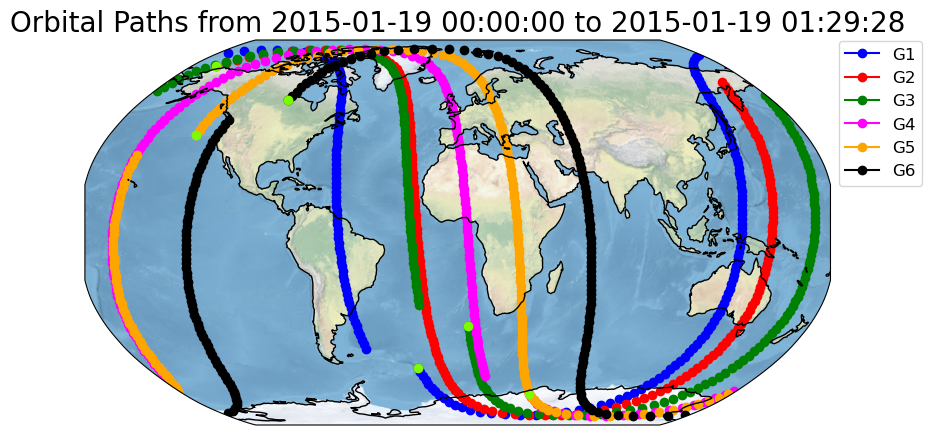

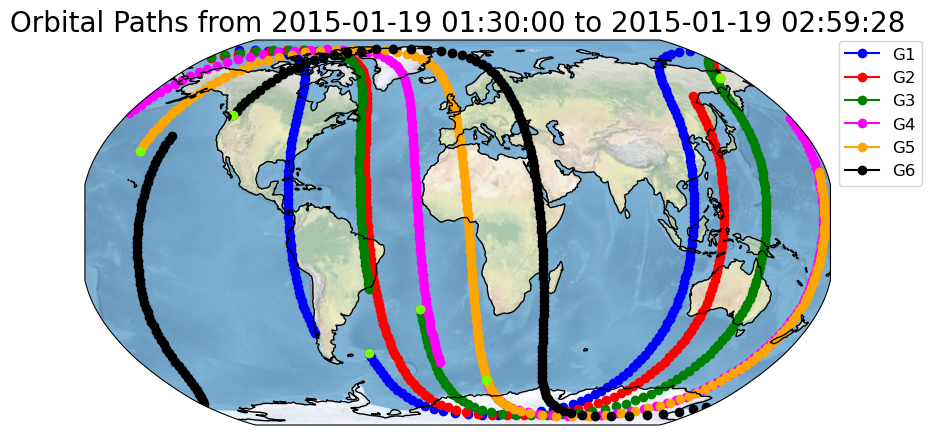

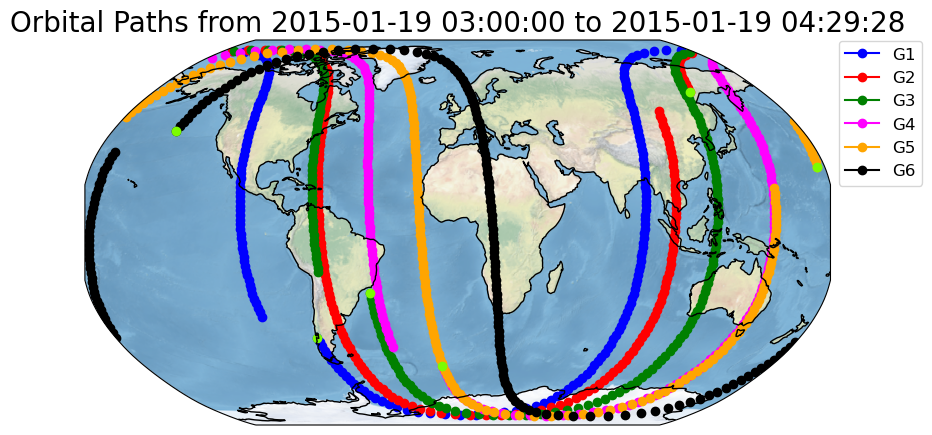

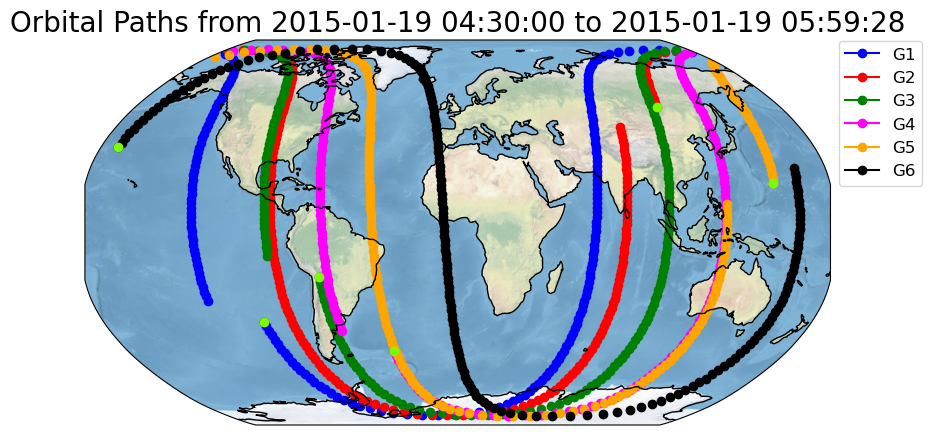

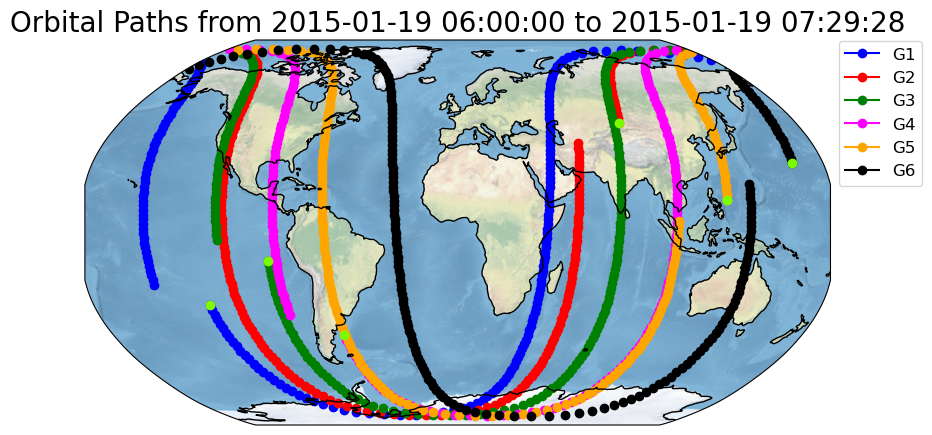

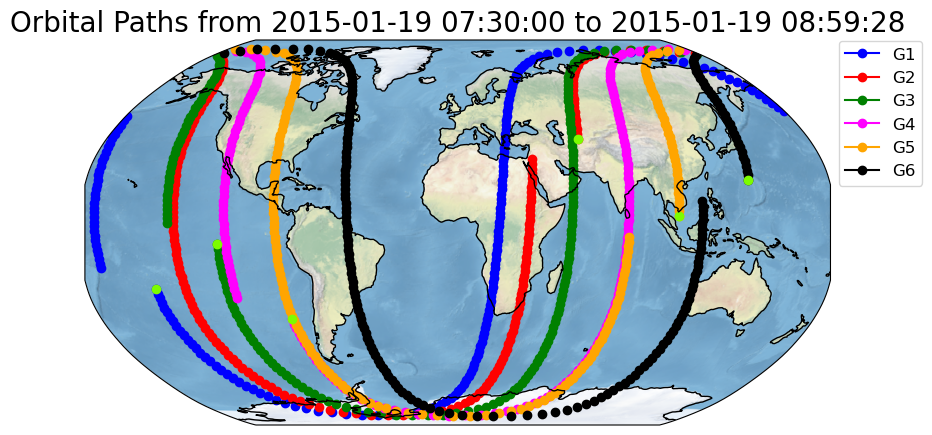

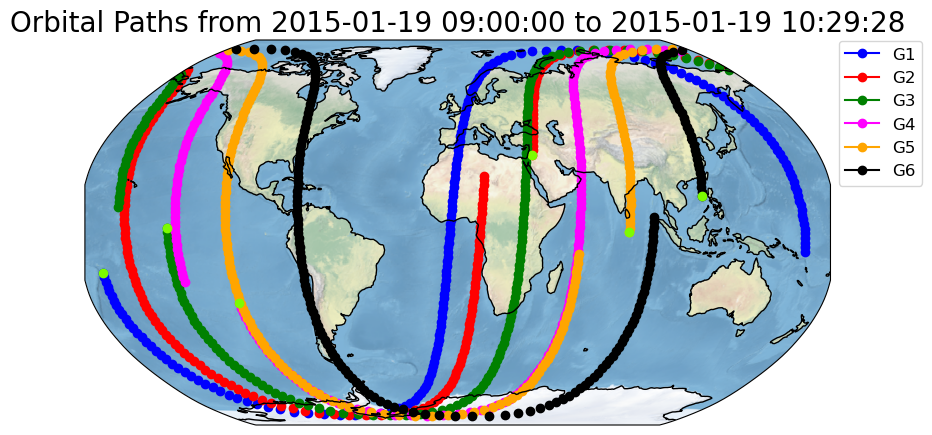

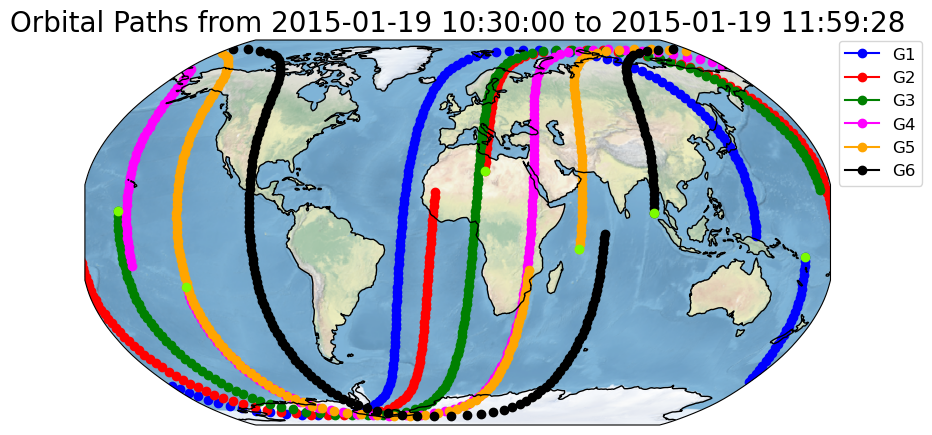

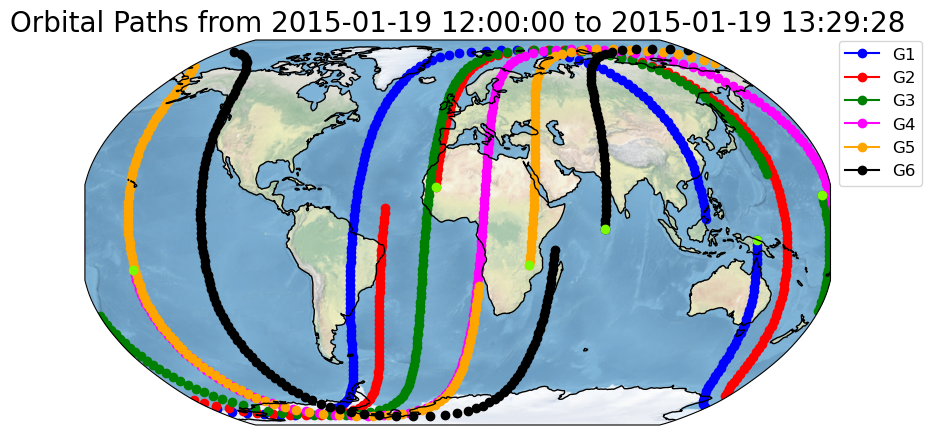

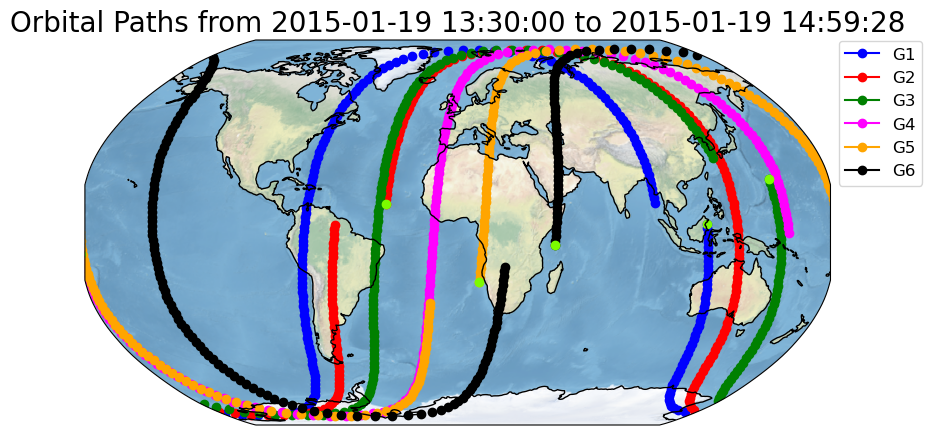

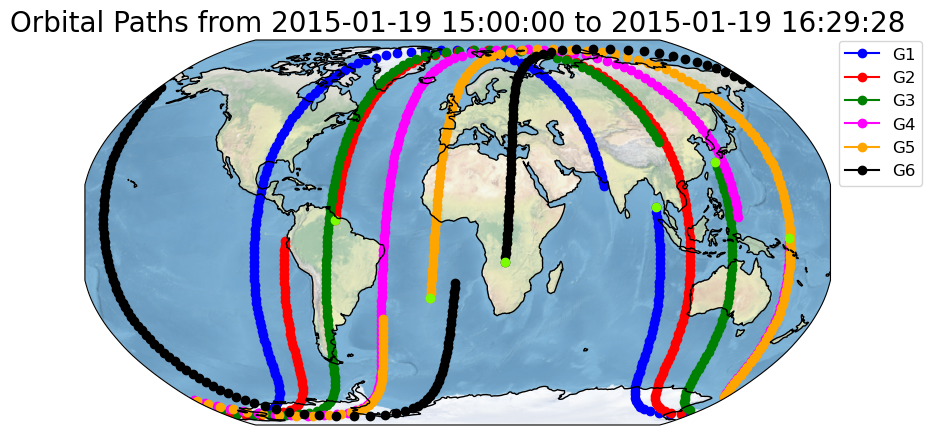

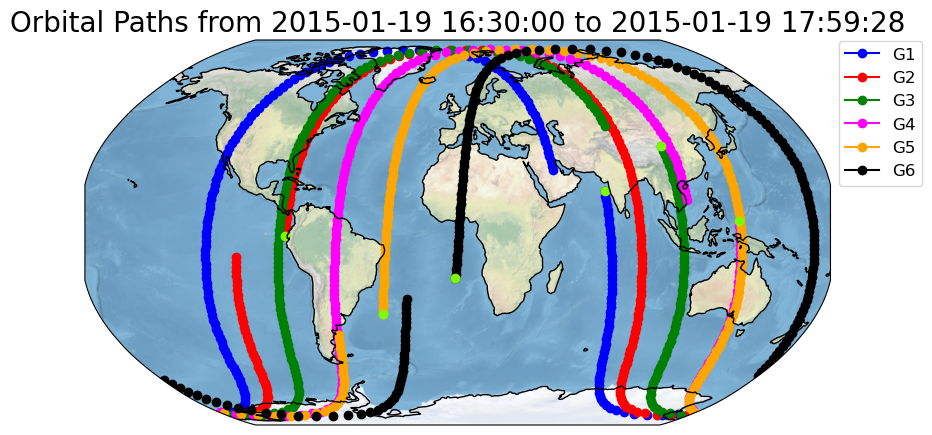

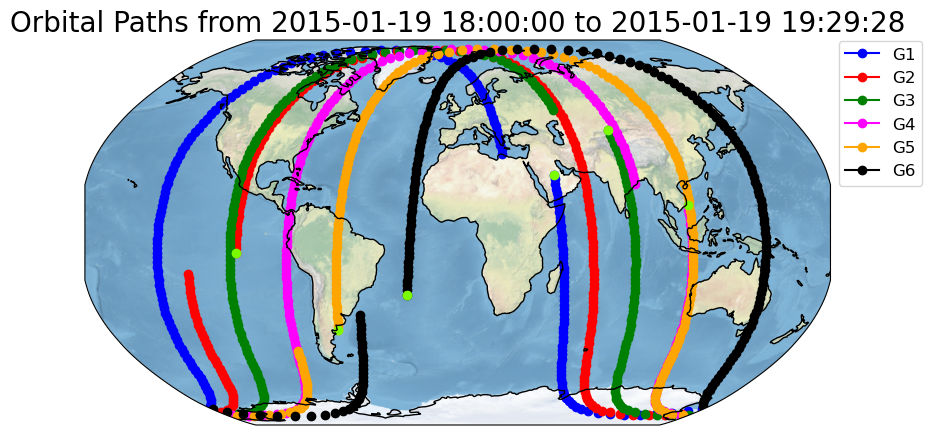

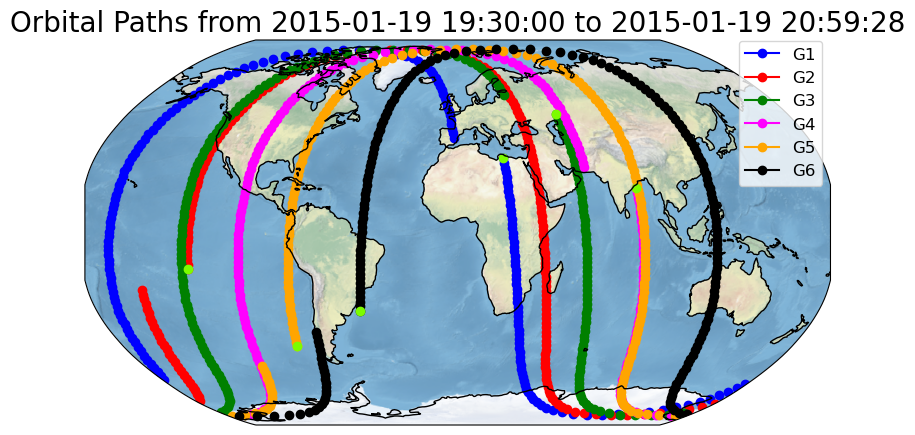

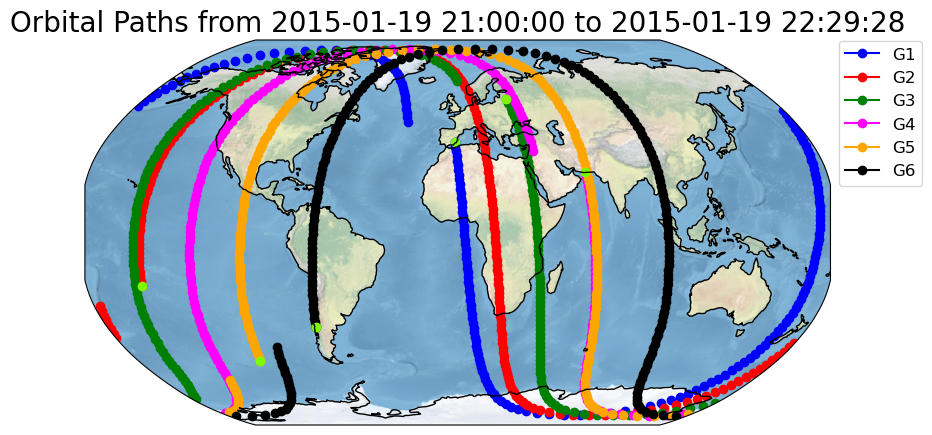

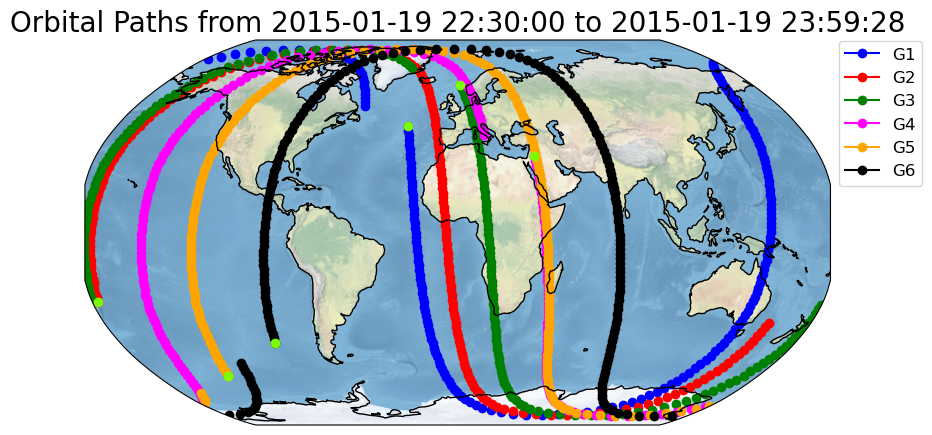

In [38]:
# Grab all satellite orbits and plot

satellites = [1,2,3,4,5,6]

sat_labels = ['G1','G2','G3','G4','G5','G6']
sat_colors = ['blue','red','green','magenta','orange','black']


Lat = np.zeros((6,len(time_e)))
Lon = np.zeros((6,len(time_e)))
Alt = np.zeros((6,len(time_e)))

c = 0
for s in satellites:
    satellite_filepath = folderpath_sat + 'gdc_drm_ephem_g' + str(s) + '_allphases.ncdf'
    satellite_file = Dataset(satellite_filepath)

    Lat[c,:] =  np.asarray(satellite_file.variables['geod_lat'])
    Lon[c,:] =  np.asarray(satellite_file.variables['geod_lon'])
    Alt[c,:] =  np.asarray(satellite_file.variables['geod_alt'])

    c += 1


# lat_loc = Lat[:,0:i_reg] #Phase 1
# lon_loc = Lon[:,0:i_reg]

# lat = lat_loc[:,0:i_d] #Day 1
# lon = lon_loc[:,0:i_d]
# alt = Alt[:,0:i_d]

lat_3a = Lat[:,i_glo+1:] #Phase 3
lon_3a = Lon[:,i_glo+1:]
alt_3a = Alt[:,i_glo+1:]

for k in range(0,16):

    index = i_d

    lat = lat_3a[:,k*index:(k+1)*index] #Day 1
    lon = lon_3a[:,k*index:(k+1)*index]
    alt = alt_3a[:,k*index:(k+1)*index]

    time_period = time_glo[k*index:(k+1)*index]

    title = 'Orbital Paths from ' + str(time_period[0]) + ' to ' + str(time_period[-1])

    lon = lon - 180

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

    # make the map global rather than have it zoom in to
    # the extents of any plotted data
    ax.set_global()
    ax.set_extent([180,-180,-90,90], ccrs.PlateCarree())
    ax.stock_img()
    ax.coastlines()

    for i in range(0,len(satellites)):
        ax.scatter(lon[i,:],lat[i,:],color = sat_colors[i],transform = ccrs.PlateCarree())
    ax.scatter(lon[:,0],lat[:,0],color='lawngreen',transform=ccrs.PlateCarree())

    legend_elements = [Line2D([0], [0], marker='o', color=sat_colors[s], label=sat_labels[s]) 
                        for s in range(0,len(satellites))]
    plt.legend(handles=legend_elements,fontsize='large',bbox_to_anchor =(1.0, 1.02),ncol=1)
    plt.title('Orbital Paths from ' + str(time_period[0]) + ' to ' + str(time_period[-1]),fontsize=20)

    plt.savefig('gif/satellite_orbits_'+ str(time_period[0]) +'.png')



In [42]:
# filepaths
fp_in = '/glade/scratch/bdilorenzo/GDC/scripts/gif/*.png'
fp_out = '/glade/scratch/bdilorenzo/GDC/scripts/gif/Day1_3b.gif'

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
imgs = (Image.open(f) for f in sorted(glob.glob(fp_in)))
img = next(imgs)  # extract first image from iterator
img.save(fp=fp_out, format='GIF', append_images=imgs,
         save_all=True, duration=600, loop=0)